## Convolutional Neural Networks

The idea behind CNNs is to create a network that learns convolution kernels against the training data and then use them to classify documents.  In this notebook, we will learn how to create a simple CNN to classify pictures in Cifar-10.

In order to run the following codes you need to first download the cifar dataset using the following command line instructions.

```
# Get CIFAR10
wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xzvf cifar-10-python.tar.gz
rm cifar-10-python.tar.gz 
```

You should modify the loading code below to reference the folder created in the above steps. in the line:

```
X_trn, y_trn, X_te, y_te = load('cifar-10-batches-py')
```

make sure you reference the relative location of the cifar-10 folder.

In [1]:
import numpy as np
import os
import _pickle as pickle
import matplotlib.pyplot as plt
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def load_CIFAR_batch(filename):
    ''' load single batch of cifar '''
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_batch_by_number(ROOT, filenum):
    return load_CIFAR_batch(os.path.join(ROOT, 'data_batch_%d' % (filenum, )))
                            
def load_test_batch(ROOT):
    return load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))

def load(ROOT):
    ''' load all of cifar '''
    xs = []
    ys = []
    for b in range(1, 6):
        #f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_batch_by_number(ROOT, b)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_test_batch(ROOT)
    return Xtr, Ytr, Xte, Yte

def preprocess_CIFAR10(X_train, y_train, X_test, y_test):
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1)) # [49000, 3072]
    X_test = np.reshape(X_test, (X_test.shape[0], -1)) # [10000, 3072]
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_test -= mean_image
    
    return X_train, y_train, X_test, y_test

def visualize_sample(X_train, y_train, classes, samples_per_class=7):
    """visualize some samples in the training datasets """
    num_classes = len(classes)
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y) # get all the indexes of cls
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs): # plot the image one by one
            plt_idx = i * num_classes + y + 1 # i*num_classes and y+1 determine the row and column respectively
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
    

frog


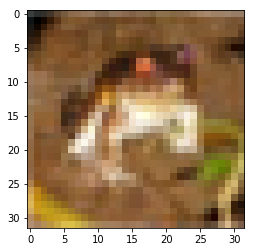

((10000, 32, 32, 3), (10000,))

In [2]:
# Load the cifar-10 images
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import os.path

reset_graph()

data_folder = '../data'

# read some data from input.
X_trn, y_trn = load_batch_by_number(os.path.join(data_folder,'cifar-10-batches-py'), 1)
X_te, y_te = load_test_batch(os.path.join(data_folder,'cifar-10-batches-py'))
print(classes[y_trn[0]])
plt.imshow(X_trn[0].astype('uint8'))
plt.show()
X_trn.shape, y_trn.shape,

In [8]:
#create the tfRecord source file

def _bytes_feature(_value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[_value]))

def _int64_feature(_value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[_value]))

tfr_storage = 'cifar-10.tfrec'

with tf.python_io.TFRecordWriter(tfr_storage) as record_writer:
    num_entries_in_batch = y_trn.shape[0]
    for i in range(num_entries_in_batch): #(num_entries_in_batch):
        img = X_trn[i]
        label = y_trn[i]
        #print(label.shape)
        
        height = img.shape[0]
        width = img.shape[1]
        channels = img.shape[2]
        raw = img.tostring()
        feature_dict = { 
            'height': _int64_feature(height),
            'width': _int64_feature(width),
            'channels': _int64_feature(channels),
            'image':_bytes_feature(raw), 
            'label': _int64_feature(label)
        }
        
        example = tf.train.Example(features=tf.train.Features(
            feature=feature_dict))
        record_writer.write(example.SerializeToString())
        
X_trn.shape, y_trn.shape

((10000, 32, 32, 3), (10000,))

In [10]:
# read data from TFRecord and prepare shuffled batches for training
reset_graph()

def create_shuffled_batches(input_file, batch_size):
    
    reader = tf.TFRecordReader();
    _, serialized_example = reader.read(input_file)
    
    # read the features from on record and convert them to apropriate objects
    features = tf.parse_single_example(
        serialized_example,
        features={
            'height': tf.FixedLenFeature([], tf.int64),
            'width': tf.FixedLenFeature([], tf.int64),
            'channels': tf.FixedLenFeature([], tf.int64),
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        })
    # image as a byte array
    image = tf.decode_raw(features['image'], tf.float64)
    
    height =   tf.cast(features['height'], tf.int32)
    width =    tf.cast(features['width'], tf.int32)
    channels = tf.cast(features['channels'], tf.int32)
    
    label = tf.cast(features['label'], tf.int32)
    label.set_shape(()) #ToDo:  This looks wrong.
    
    # fix up the image shape
#    image_shape = tf.stack([height, width, channels])
    image_shape = tf.stack([32, 32, 3])

    image = tf.reshape(image, image_shape)
    image.set_shape((32, 32, 3))
    
    image, label =  tf.train.shuffle_batch( [image, label],
                                    batch_size=batch_size,
                                    capacity=300,
                                    num_threads=2,
                                    min_after_dequeue=100)
    
    return image, label


(5, 32, 32, 3)
(5,)
bird


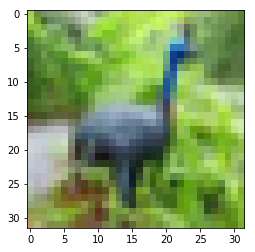

car


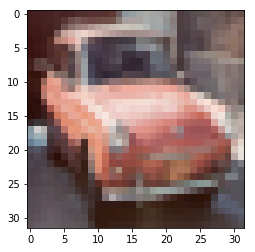

truck


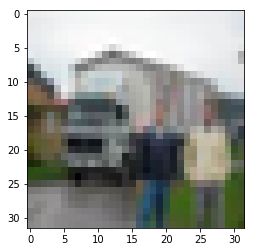

truck


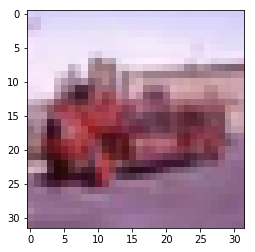

ship


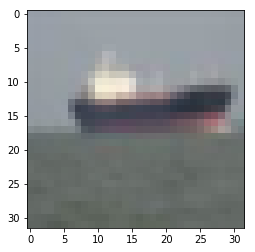

(5, 32, 32, 3)
(5,)
horse


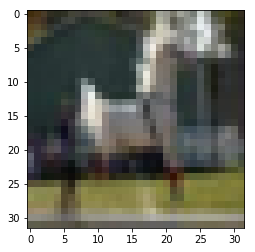

horse


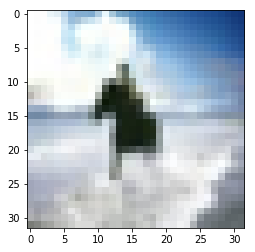

frog


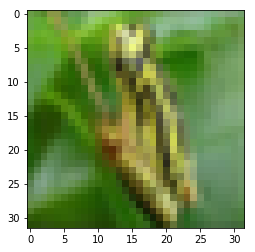

deer


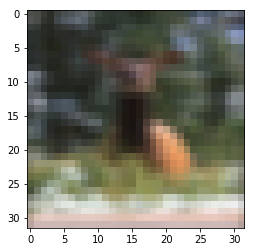

dog


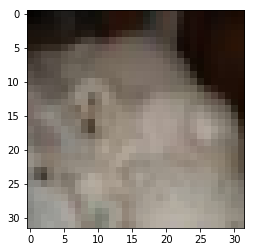

(5, 32, 32, 3)
(5,)
ship


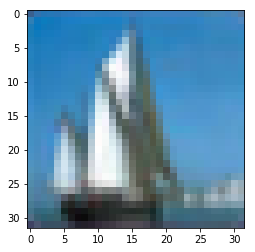

deer


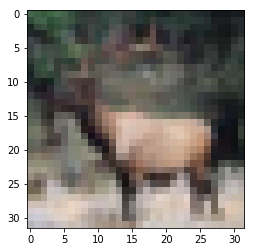

horse


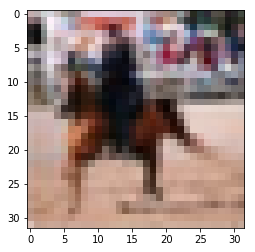

ship


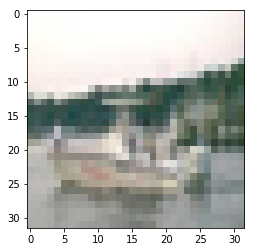

frog


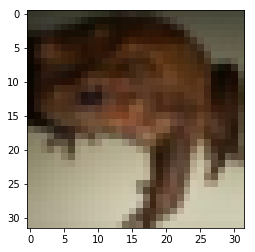

In [12]:
#run the batcher
filename_queue = tf.train.string_input_producer(
    [tfr_storage], num_epochs=1)

# Even when reading in multiple threads, share the filename
# queue.
image, label = create_shuffled_batches(filename_queue, 5)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in range(3):
    
        img, lbl = sess.run([image, label])
        print(img.shape)
        print(lbl.shape)
        for i in range(lbl.shape[0]):
            print(classes[lbl[i].astype('int32')])
            plt.imshow(img[i].astype('uint8')) 
            plt.show() 
        
    coord.request_stop()
    coord.join(threads)

In order to manage convolutional networks, it's important to keep track of the size of the output at each layer.  Below we start with 32X32X3 inputs. after conv1, we have created a layer with 28X28X1.  the pooling layer reduces this by half to 14X14X1

In [66]:
# class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

reset_graph()

# tensorflow stuff
X = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name = "X")
y = tf.placeholder(tf.int32, shape=[None], name="y")

# layer1 - 2 kernels, 3x3 stride=1
conv1 = tf.layers.conv2d(X, filters=64, kernel_size=[3, 3], strides=[1,1], padding = 'SAME', activation=tf.nn.relu)

# layer2 - pool 2X2 max
#pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

conv2 = tf.layers.conv2d(conv1, filters=64, kernel_size=[3, 3], strides=[1,1], padding = 'SAME', activation=tf.nn.relu)

# layer2 - pool 2X2 max
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

conv3 = tf.layers.conv2d(pool2, filters=32, kernel_size=[3, 3], strides=[1,1], padding = 'SAME', activation=tf.nn.relu)

pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)

# flatten pooling results
pool_shape = pool3.get_shape().as_list()
pool_flat = tf.reshape(pool3, shape=[-1, pool_shape[1]*pool_shape[2]*pool_shape[3]])

# fully connected
fc1 = tf.layers.dense(pool_flat, units=512, activation=tf.nn.relu)

fc2 = tf.layers.dense(fc1, units=256, activation=tf.nn.relu)

# dropout layer
#dropout = tf.layers.dropout(inputs=fc2, rate=0.5)

# z-function  (logits)
y_proba = tf.layers.dense(inputs=fc2, units=10, name = "z", activation=tf.nn.softmax)

predicted = tf.cast(tf.argmax(tf.transpose(y_proba)), tf.int32)

#correct_predictions = tf.equal(tf.argmax(tf.transpose(y_proba), 1), tf.argmax(y, 1))
correct_predictions = tf.equal(predicted, y)

accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"))

# training parts of the graph
onehot_labels = tf.one_hot(indices=tf.cast(y, tf.int32), depth=10)
xentropy = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=y_proba)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
training_op = optimizer.minimize(
        loss=tf.reduce_mean(xentropy),
        global_step=tf.train.get_global_step())

#loss = tf.reduce_mean(xentropy)
#optimizer = tf.train.AdamOptimizer()
#training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()



In [67]:
def test_fraction(x_test, y_test, fraction):
    indexes = np.random.permutation(y_test.shape[0])
    limit = int(indexes.shape[0]*fraction)
    new_X = x_test[indexes[:limit, ...]]
    new_y = y_test[indexes[:limit]]
    return new_X, new_y
    
n_epochs = 500
batch_size = int(50)

#run the batcher
filename_queue = tf.train.string_input_producer(
    [tfr_storage], num_epochs=n_epochs)

# Even when reading in multiple threads, share the filename
# queue.
image_batch, label_batch = create_shuffled_batches(filename_queue, batch_size)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())


with tf.Session() as sess:
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    for epoch in range(n_epochs):
        for iteration in range(int(X_trn.shape[0] // batch_size)):
            X_batch, y_batch = sess.run([image_batch, label_batch])
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            acc_train = correct_predictions.eval(feed_dict={X: X_batch, y: y_batch})

        # print every 10 epochs
        if epoch % 10 == 0:
            # batch the test data to smaller random chuncks 
            # so that we can use bigger convolution steps.
            new_X_te, new_y_te = test_fraction(X_te, y_te, 0.5)
            print(new_X_te.shape)
            acc_test = accuracy.eval(feed_dict={X: new_X_te, y: new_y_te})
            print(epoch, "Train accuracy:", sum(acc_train)/batch_size, "Test accuracy:", acc_test)

#        save_path = saver.save(sess, "./my_cifar_model")
    coord.request_stop()
    coord.join(threads)

(5000, 32, 32, 3)
0 Train accuracy: 0.14 Test accuracy: 0.1326
(5000, 32, 32, 3)
10 Train accuracy: 0.24 Test accuracy: 0.228
(5000, 32, 32, 3)
20 Train accuracy: 0.38 Test accuracy: 0.3368
(5000, 32, 32, 3)
30 Train accuracy: 0.5 Test accuracy: 0.381
(5000, 32, 32, 3)
40 Train accuracy: 0.6 Test accuracy: 0.4074
(5000, 32, 32, 3)
50 Train accuracy: 0.44 Test accuracy: 0.447
(5000, 32, 32, 3)
60 Train accuracy: 0.54 Test accuracy: 0.4262
(5000, 32, 32, 3)
70 Train accuracy: 0.6 Test accuracy: 0.4462
(5000, 32, 32, 3)
80 Train accuracy: 0.62 Test accuracy: 0.4442
(5000, 32, 32, 3)
90 Train accuracy: 0.56 Test accuracy: 0.4436
(5000, 32, 32, 3)
100 Train accuracy: 0.62 Test accuracy: 0.4554
(5000, 32, 32, 3)
110 Train accuracy: 0.66 Test accuracy: 0.4588
(5000, 32, 32, 3)
120 Train accuracy: 0.58 Test accuracy: 0.4616
(5000, 32, 32, 3)
130 Train accuracy: 0.64 Test accuracy: 0.4564
(5000, 32, 32, 3)
140 Train accuracy: 0.62 Test accuracy: 0.4616
(5000, 32, 32, 3)
150 Train accuracy: 0.66